In [ ]:
### 3-D Image Generation using GAN ###############

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [3]:
import numpy as np

# Ml libraries
import tensorflow as tf # '2.2.0'
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda, Concatenate, Multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose 
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

# dataset
import tensorflow_datasets as tfds

# visualization
import skimage
from skimage import data, color, exposure
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

# sys and helpers
import sys
import os
import glob
from tqdm import tqdm
from datetime import datetime

In [ ]:
# device check
from tensorflow.python.client import device_lib
print('Devices:', device_lib.list_local_devices())

# GPU check
if not tf.test.gpu_device_name():
    print('No GPU found.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11561480333393321890
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8517472854689173822
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Default GPU Device: /device:GPU:0


In [ ]:
os.chdir('/content')

In [ ]:
def timer(start_time=None):
  if not start_time:
      start_time = datetime.now()
      return start_time
  elif start_time:
      thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
      tmin, tsec = divmod(temp_sec, 60)
      print('Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
def load_dataset(dataset, width, height, channels, class_label_list=None):
  if dataset == 'smallnorb':
      # load smallnorb dataset
      X_train, y_train = tfds.as_numpy(tfds.load(
                        'smallnorb',
                        split='train', 
                        batch_size=-1, 
                        as_supervised=True,
                    ))
      
      if class_label_list:
          uniq_levels = np.unique(y_train)
          uniq_counts = {level: sum(y_train == level) for level in uniq_levels}
          # find observation index of each class levels
          groupby_levels = {}
          for ii, level in enumerate(uniq_levels):
              obs_idx = [idx for idx, val in enumerate(y_train) if val == level]
              groupby_levels[level] = obs_idx

          copy_idx = []
          for class_label in class_label_list:
            copy_idx = copy_idx + groupby_levels.get(class_label)

          X_train = X_train[copy_idx]

      X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
  # defining input dims
  img_rows = width
  img_cols = height
  channels = channels
  img_shape = [img_rows, img_cols, channels]

  return X_train, img_shape
    

dataset, shape = load_dataset('smallnorb', 96, 96, 1, [4])
print('Dataset shape: {0}, Image shape: {1}'.format(dataset.shape, shape))


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/24300 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/smallnorb/2.0.0.incomplete0YYCL9/smallnorb-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/24300 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/smallnorb/2.0.0.incomplete0YYCL9/smallnorb-test.tfrecord*...:   0%|          |…

Dataset smallnorb downloaded and prepared to ~/tensorflow_datasets/smallnorb/2.0.0. Subsequent calls will reuse this data.
Dataset shape: (4860, 96, 96, 1), Image shape: [96, 96, 1]


In [ ]:
len(dataset)

4860

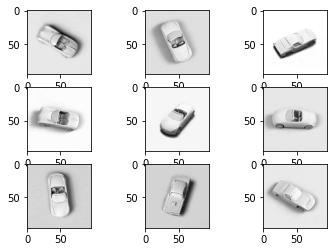

In [ ]:
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(dataset[i,:,:,0], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [ ]:
# squash function of capsule layers, borrowed from Xifeng Guo's implementation of Keras CapsNet `https://github.com/XifengGuo/CapsNet-Keras`
def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [ ]:
# discriminator structure
def build_discriminator():

    """
    This is the part my 'Capsule Layer as a Discriminator in Generative Adversarial Networks' paper focuses on,
    as it introduces a new structure to the discriminator of DCGAN by using Capsule Layers architecture from original
    'Dynamic Routing Between Capsules' paper by S. Sabour, N. Frosst and G. Hinton.
    
    Discriminator takes real/generated images and outputs its prediction.
    """

    # depending on dataset we define input shape for our network
    img = Input(shape=(shape[0], shape[1], shape[2]))

    # first typical convlayer outputs a 20x20x256 matrix
    x = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', name='conv1')(img)
    x = LeakyReLU()(x)
    
    # original 'Dynamic Routing Between Capsules' paper does not include the batch norm layer after the first conv group
    x = BatchNormalization(momentum=0.8)(x)

    
    """
    NOTE: Capsule architecture starts from here.
    """
    #
    # primarycaps coming first
    #
    
    # filters 256 (n_vectors=8 * channels=32)
    x = Conv2D(filters=8 * 32, kernel_size=9, strides=2, padding='valid', name='primarycap_conv2')(x)
    
    # reshape into the 8D vector for all 32 feature maps combined
    # (primary capsule has collections of activations which denote orientation of the digit
    # while intensity of the vector which denotes the presence of the digit)
    x = Reshape(target_shape=[-1, 8], name='primarycap_reshape')(x)
    
    # the purpose is to output a number between 0 and 1 for each capsule where the length of the input decides the amount
    x = Lambda(squash, name='primarycap_squash')(x)
    x = BatchNormalization(momentum=0.8)(x)


    #
    # digitcaps are here
    #
    """
    NOTE: My approach is a simplified version of digitcaps i.e. without expanding dimensions into
    [None, 1, input_n_vectors, input_dim_capsule (feature maps)]
    and tiling it into [None, num_capsule, input_n_vectors, input_dim_capsule (feature maps)].
    Instead I replace it with ordinary Keras Dense layers as weight holders in the following lines.
    
    ANY CORRECTIONS ARE APPRECIATED IN THIS PART, PLEASE SUBMIT PULL REQUESTS!
    """
    x = Flatten()(x)
    # capsule (i) in a lower-level layer needs to decide how to send its output vector to higher-level capsules (j)
    # it makes this decision by changing scalar weight (c=coupling coefficient) that will multiply its output vector and then be treated as input to a higher-level capsule
    #
    # uhat = prediction vector, w = weight matrix but will act as a dense layer, u = output from a previous layer
    # uhat = u * w
    # neurons 160 (num_capsules=10 * num_vectors=16)
    uhat = Dense(160, kernel_initializer='he_normal', bias_initializer='zeros', name='uhat_digitcaps')(x)
    
    # c = coupling coefficient (softmax over the bias weights, log prior) | "the coupling coefficients between capsule (i) and all the capsules in the layer above sum to 1"
    # we treat the coupling coefficiant as a softmax over bias weights from the previous dense layer
    c = Activation('softmax', name='softmax_digitcaps1')(uhat) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    
    # s_j (output of the current capsule level) = uhat * c
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    """
    NOTE: Squashing the capsule outputs creates severe blurry artifacts, thus we replace it with Leaky ReLu.
    """
    s_j = LeakyReLU()(x)


    #
    # we will repeat the routing part 2 more times (num_routing=3) to unfold the loop
    #
    c = Activation('softmax', name='softmax_digitcaps2')(s_j) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    c = Activation('softmax', name='softmax_digitcaps3')(s_j) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    pred = Dense(1, activation='sigmoid')(s_j)

    
    return Model(img, pred)


In [ ]:
# build and compile the discriminator
discriminator = build_discriminator()
print('DISCRIMINATOR:')
discriminator.summary()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

DISCRIMINATOR:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 88, 88, 256)  20992       ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 88, 88, 256)  0           ['conv1[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 88, 88, 256)  1024       ['leaky_re_lu[0][0]']            
 alization)                                                                    

In [ ]:
# generator structure
def build_generator():

    """
    Generator follows the DCGAN architecture and creates generated image representations through learning.
    """

    noise_shape = (100,)
    x_noise = Input(shape=noise_shape)

    # we apply different kernel sizes in order to match the original image size
    
    if (shape[0] == 96 and shape[1] == 96):
        x = Dense(256 * 24 * 24, activation="relu")(x_noise)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        x = Reshape((24, 24, 256))(x)
        x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        gen_out = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
        
        return Model(x_noise, gen_out)

In [ ]:
# build and compile the generator
generator = build_generator()
print('GENERATOR:')
generator.summary()
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

GENERATOR:
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 147456)            14893056  
                                                                 
 batch_normalization_2 (Batc  (None, 147456)           589824    
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 147456)            0         
                                                                 
 reshape (Reshape)           (None, 24, 24, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 24, 24, 128)      819200    
 nspose)                                        

In [ ]:
# build and compile the generator
generator = build_generator()
print('GENERATOR:')
generator.summary()
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

GENERATOR:
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_5 (Dense)             (None, 147456)            14893056  
                                                                 
 batch_normalization_5 (Batc  (None, 147456)           589824    
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 147456)            0         
                                                                 
 reshape_1 (Reshape)         (None, 24, 24, 256)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 24, 24, 128)      819200    
 ranspose)                                      

In [ ]:
# build and compile the generator
generator = build_generator()
print('GENERATOR:')
generator.summary()
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

GENERATOR:
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_6 (Dense)             (None, 147456)            14893056  
                                                                 
 batch_normalization_8 (Batc  (None, 147456)           589824    
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 147456)            0         
                                                                 
 reshape_2 (Reshape)         (None, 24, 24, 256)       0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 24, 24, 128)      819200    
 ranspose)                                      

In [ ]:
# feeding noise to generator
z = Input(shape=(100,))
img = generator(z)

In [ ]:
# for the combined model we will only train the generator
discriminator.trainable = False

In [ ]:
# try to discriminate generated images
valid = discriminator(img)

In [ ]:
# the combined model (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, valid)
print('COMBINED:')
combined.summary()
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

COMBINED:
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_3 (Functional)        (None, 96, 96, 1)         16509248  
                                                                 
 model (Functional)          (None, 1)                 70944321  
                                                                 
Total params: 87,453,569
Trainable params: 16,213,952
Non-trainable params: 71,239,617
_________________________________________________________________


In [ ]:
# loss values for further plotting
D_L_REAL = []
D_L_FAKE = []
D_L = []
D_ACC = []
G_L = []

In [ ]:
def train(dataset_title, epochs, batch_size=64, save_interval=50):

        half_batch = int(batch_size / 2)
        
        for epoch in range(epochs):
            start_time = timer(None) # timing starts from this point for "start_time" variable
            # ---------------------
            #  Train Discriminator
            # ---------------------

            # select a random half batch of images
            idx = np.random.randint(0, dataset.shape[0], half_batch)
            imgs = dataset[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # generate a half batch of new images
            gen_imgs = generator.predict(noise)

            # train the discriminator by feeding both real and fake (generated) images one by one
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1))*0.9) # 0.9 for label smoothing
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # the generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * 32)

            # train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            D_L_REAL.append(d_loss_real)
            D_L_FAKE.append(d_loss_fake)
            D_L.append(d_loss)
            D_ACC.append(d_loss[1])
            G_L.append(g_loss)

            # if at save interval => save generated image samples
            if epoch % save_interval == 0:
                save_imgs(dataset_title, epoch)
            timer(start_time) # timing ends here for "start_time" variable


In [ ]:
def save_imgs(dataset_title, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = generator.predict(noise)

        fig, axs = plt.subplots(r, c)
        cnt = 0
        
        # iterate in order to create a subplot
        for i in range(r):
            for j in range(c):
                if dataset_title == 'smallnorb':
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0]* 127.5 + 127.5, cmap='gray')
                    axs[i,j].axis('off')
                    cnt += 1
                else:
                    print('Please indicate the image options.')
        
        if not os.path.exists('images_{0}'.format(dataset_title)):
            os.makedirs('images_{0}'.format(dataset_title))
        
        fig.savefig("images_{0}/{1}.png".format(dataset_title, epoch))
        plt.close()

In [ ]:
start_time = timer(None) # timing starts from this point for "start_time" variable
history = train('smallnorb', epochs=3000, batch_size=64, save_interval=50)
timer(start_time) # timing ends here for "start_time" variable
generator.save('smallnorb_model.h5')

Streaming output truncated to the last 5000 lines.
Time taken: 0 hours 0 minutes and 0.98 seconds.
1/1 [==============================] - 0s 18ms/step
1345 [D loss: 0.282049, acc.: 50.00%] [G loss: 17.701126]
Time taken: 0 hours 0 minutes and 1.0 seconds.
1/1 [==============================] - 0s 16ms/step
1346 [D loss: 0.218239, acc.: 50.00%] [G loss: 18.736275]
Time taken: 0 hours 0 minutes and 1.28 seconds.
1/1 [==============================] - 0s 22ms/step
1347 [D loss: 0.283542, acc.: 48.44%] [G loss: 20.281502]
Time taken: 0 hours 0 minutes and 1.01 seconds.
1/1 [==============================] - 0s 16ms/step
1348 [D loss: 0.206030, acc.: 50.00%] [G loss: 17.455660]
Time taken: 0 hours 0 minutes and 0.98 seconds.
1/1 [==============================] - 0s 16ms/step
1349 [D loss: 0.200159, acc.: 50.00%] [G loss: 18.221569]
Time taken: 0 hours 0 minutes and 1.0 seconds.
1/1 [==============================] - 0s 17ms/step
1350 [D loss: 0.201374, acc.: 50.00%] [G loss: 19.779099]
1/1

In [ ]:
save_imgs('smallnorb',3000)

1/1 [==============================] - 0s 19ms/step


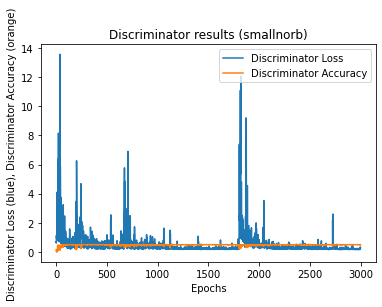

In [ ]:
plt.plot(D_L)
plt.title('Discriminator results (smallnorb)')
plt.xlabel('Epochs')
plt.ylabel('Discriminator Loss (blue), Discriminator Accuracy (orange)')
plt.legend(['Discriminator Loss', 'Discriminator Accuracy'])
plt.show()

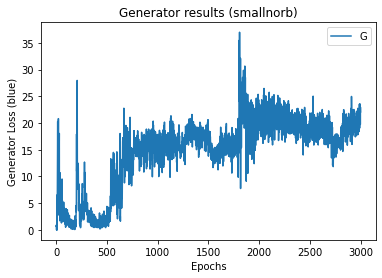

In [ ]:
plt.plot(G_L)
plt.title('Generator results (smallnorb)')
plt.xlabel('Epochs')
plt.ylabel('Generator Loss (blue)')
plt.legend('Generator Loss')
plt.show()

In [ ]:
!pip install --target=$nb_path diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 453 kB 25.8 MB/s 
     |████████████████████████████████| 772 kB 63.9 MB/s 
     |████████████████████████████████| 182 kB 63.0 MB/s 
     |████████████████████████████████| 17.1 MB 3.1 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 3.2 MB 61.8 MB/s 
     |████████████████████████████████| 78 kB 8.4 MB/s 
     |████████████████████████████████| 701 kB 52.0 MB/s 
     |████████████████████████████████| 40 kB 6.3 MB/s 
     |████████████████████████████████| 98 kB 9.9 MB/s 
     |████████████████████████████████| 61 kB 115 kB/s 
     |████████████████████████████████| 140 kB 75.5 MB/s 
     |████████████████████████████████| 161 kB 78.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depe

In [2]:
!pip install --target=$nb_path transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 22.3 MB/s 
     |████████████████████████████████| 7.6 MB 70.4 MB/s 
     |████████████████████████████████| 182 kB 75.6 MB/s 


In [ ]:
### Using Transformer For Estimating Depth ###

### Dense Prediction Transformer (DPT) model trained on 1.4 million images for monocular depth estimation. ###

### DPT uses the Vision Transformer (ViT) as backbone and adds a neck + head on top for monocular depth estimation. ##

### Developed by Intel AI in partnership with hugging face .

In [3]:
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

In [4]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/942 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model.save_pretrained('./content/my_checkpoint')

In [ ]:
from google.colab import files
files.download('/content/content/my_checkpoint/pytorch_model.bin') 

In [31]:
!gdown --id 1z_eT514alLgiXg1QcHYYgmLKqMm9XUjW

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z_eT514alLgiXg1QcHYYgmLKqMm9XUjW
To: /content/Depth_estimation_01.jpg
100% 85.7k/85.7k [00:00<00:00, 88.3MB/s]


In [32]:
image = Image.open('/content/Depth_estimation_01.jpg')

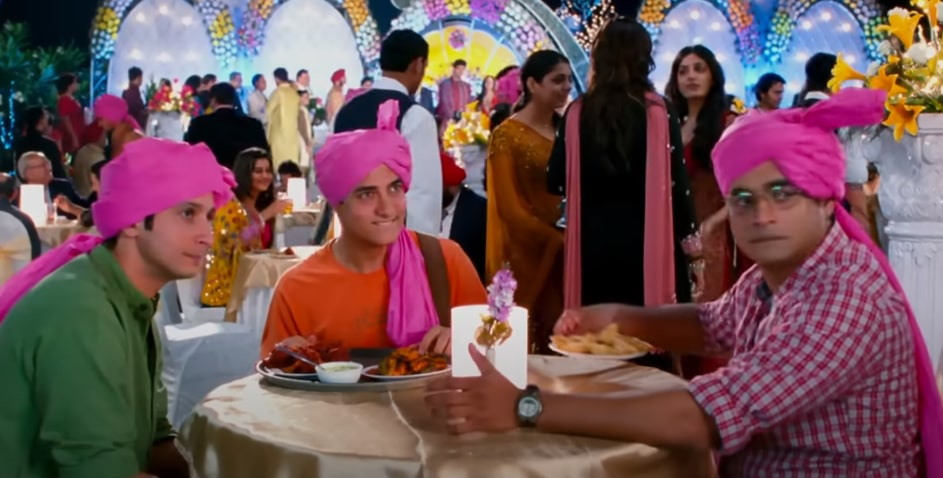

In [33]:
image

In [34]:
# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

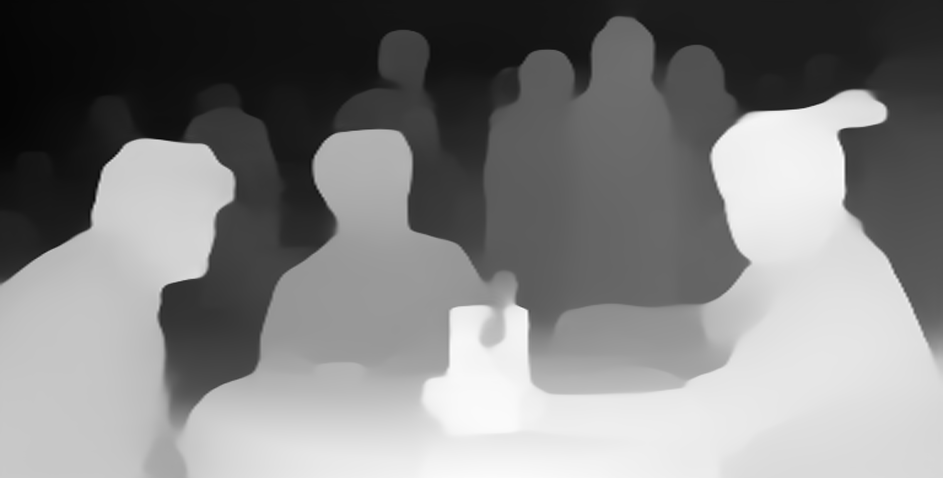

In [35]:
depth

In [1]:
!gdown --id 1U1c3RTh64Cyn9B-Pvb6-VAE2GFhVgqBO

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1U1c3RTh64Cyn9B-Pvb6-VAE2GFhVgqBO
To: /content/DSC_0521.JPG
100% 6.56M/6.56M [00:00<00:00, 173MB/s]


In [5]:
from PIL import Image
image = Image.open('/content/DSC_0521.JPG')

In [38]:
# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

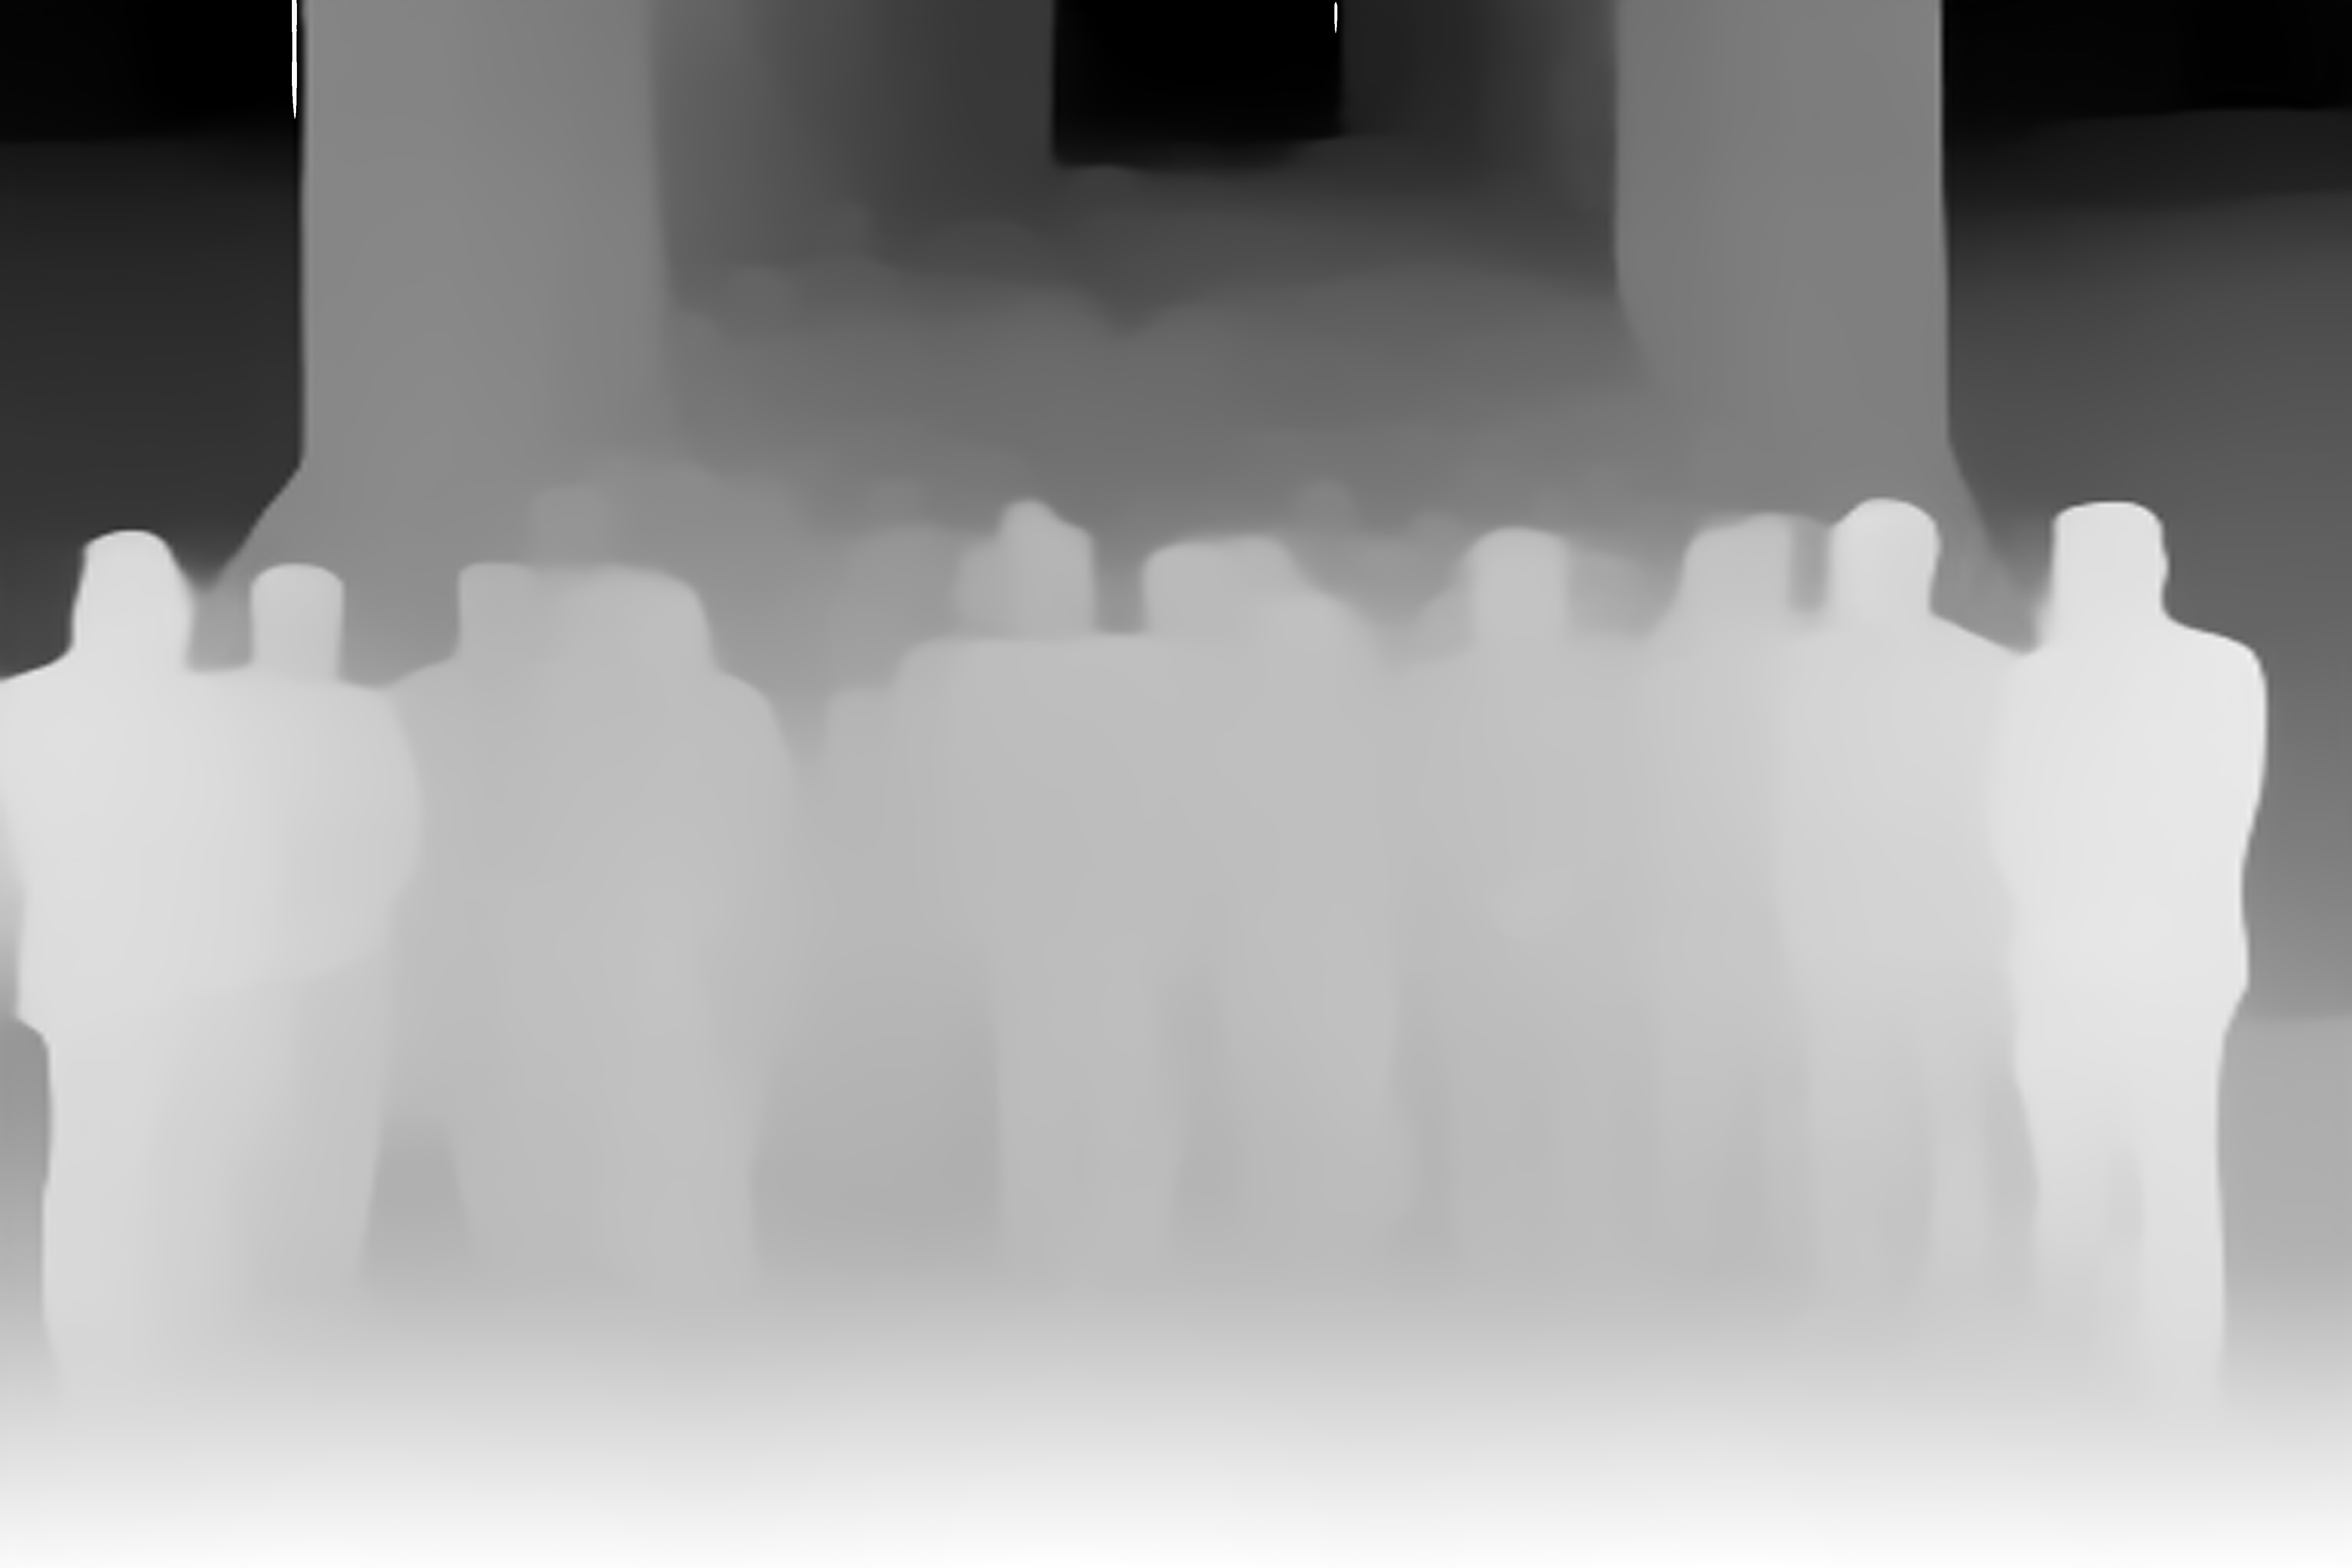

In [39]:
depth